In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct

from nnn import util, fileio, processing, plotting, motif_fit

import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy import stats
from sklearn.metrics import r2_score

## Loading data

In [97]:
annotation = pd.read_csv('./data/annotation/NNNlib2b_annotation_20220316.tsv', sep='\t').set_index('SEQID')
r1 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz', annotation=annotation)
r2 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz')
r3 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211221_v8.CPvariant.gz')
r4 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211223_v6.CPvariant.gz')

30987 / 32379, 95.70% varaints passed the chi2 test
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28424 / 28756, 98.85% varaints passed the chi2 test
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28539 / 28756, 99.25% varaints passed the chi2 test
86.08% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28014 / 28755, 97.42% varaints passed the chi2 test
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [9]:
salt = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20220314_v1.CPvariant.gz', annotation=annotation, sodium=0.150)

31324 / 34331, 91.24% varaints passed the chi2 test
38.54% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


## Forward-reverse vs forward replicates

In [15]:
df = r3[['dG_37']].join( r4[['dG_37']], lsuffix='_melt', rsuffix='_anneal' , how='inner')
r2_score(df.dG_37_melt, df.dG_37_anneal)

0.8579214986973616

In [17]:
df = r2[['dG_37']].join( r3[['dG_37']], lsuffix='_melt_r1', rsuffix='_melt_r2' , how='inner')
r2_score(df.dG_37_melt_r1, df.dG_37_melt_r2)

0.9832156548212994

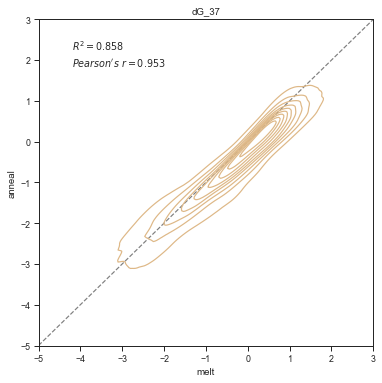

In [24]:
plotting.plot_rep_comparison(r3, r4, param='dG_37', lim=[-5,3], kind='kde')
plt.xlabel('melt')
plt.ylabel('anneal')
util.save_fig('./fig/melt_anneal/compare_all_melt-anneal.pdf')

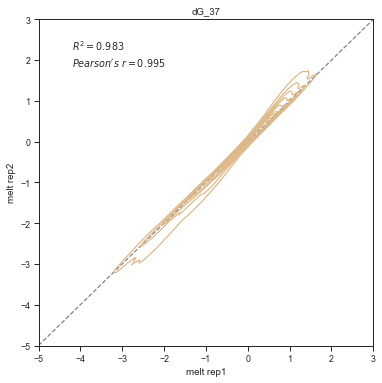

In [25]:
plotting.plot_rep_comparison(r2, r3, param='dG_37', lim=[-5,3], kind='kde')
plt.xlabel('melt rep1')
plt.ylabel('melt rep2')
util.save_fig('./fig/melt_anneal/compare_all_melt-reps.pdf')

Series Bulges,  8432 variants
Series TETRAloop,  3768 variants
Series MisMatchesGTanyPos,  3367 variants
Series MisMatchesACanyPos,  2719 variants
Series MisMatchesCentered,  2449 variants
Series WatsonCrick,  2275 variants
Series TRIloop,  954 variants
Series PUMcontrols,  30 variants
Series REPeatControls,  28 variants
Series BaeControls,  6 variants
Series PolyNTControls,  6 variants
Series VariableLoops,  6 variants


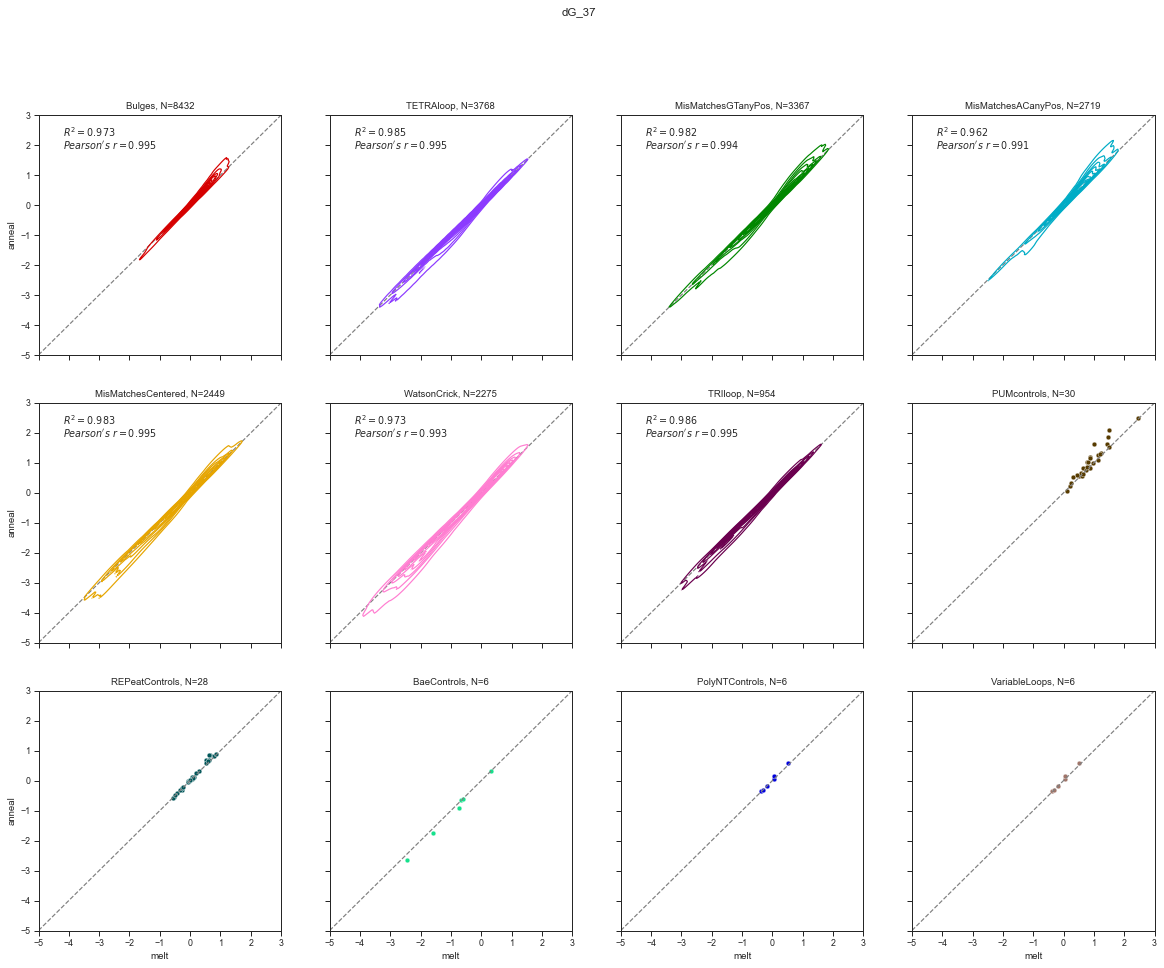

In [34]:
plotting.plot_rep_comparison_by_series(r2, r3, annotation, param='dG_37', lim=[-5,3],
        suffixes=('_x', '_y'), xlabel='melt', ylabel='anneal')
util.save_fig('./fig/melt_anneal/dG_37_by_series_rep.pdf')

## Does NUPACK predict non-two-state behavior?

In [36]:
annotation['fold_agree'] = annotation.TargetStruct == annotation.mfe_struct_Na_1M_0C

In [50]:
class_agree = annotation.groupby('ConstructClass').sum()[['fold_agree']].join(pd.DataFrame(annotation.groupby('ConstructClass').apply(len), columns=['num']))
class_agree = class_agree.drop('Pseudo knots')

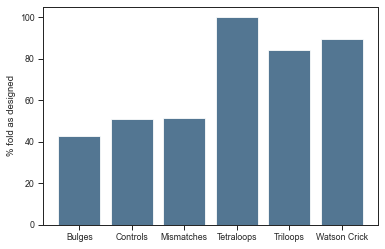

In [61]:
plt.bar(class_agree.index, 100 * class_agree.fold_agree / class_agree.num, color='#537692')
plt.ylabel('% fold as designed')
util.save_fig('./fig/folding/percent_fold_as_designed.pdf')

In [132]:
r1_anno = r3.join(annotation)

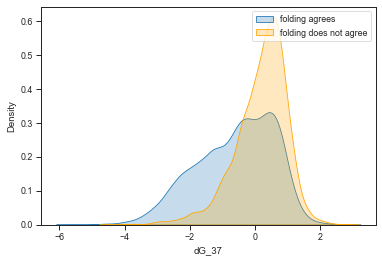

In [147]:
metric = 'dG_37'
fold_agree_red_chisq = r1_anno[r1_anno.fold_agree][metric]
fold_not_agree_red_chisq = r1_anno[np.logical_not(r1_anno.fold_agree)][metric]

sns.kdeplot(fold_agree_red_chisq.values, fill=True)
sns.kdeplot(fold_not_agree_red_chisq, color='orange', fill=True)
# plt.xlim([0,2])
plt.legend(['folding agrees', 'folding does not agree'])
util.save_fig(f'./fig/folding/fold_agree_{metric}.pdf')

In [89]:
fold_agree_red_chisq.sum() / len(fold_agree_red_chisq)

0.9898371762648891

In [90]:
fold_not_agree_red_chisq.sum() / len(fold_not_agree_red_chisq)

0.9863931553448099

<AxesSubplot:xlabel='chisq'>

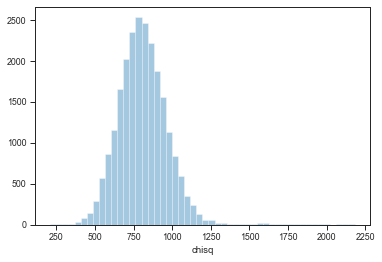

In [100]:
sns.distplot(r4.chisq, kde=False)

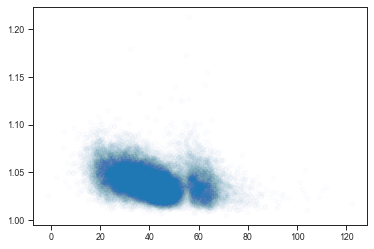

In [10]:
plt.scatter(r1.Tm-273, r1.red_chisq, alpha=.01)

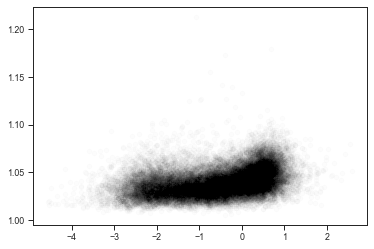

In [14]:
plt.scatter(r1.dG_37, r1.red_chisq, alpha=.01, c='k')

In [73]:
rep = r2
med = rep[[c for c in rep.columns if c.endswith('_norm')]]
std = rep[[c for c in rep.columns if c.endswith('_norm_std')]]
std.median(axis=0)

Green12_20.0_norm_std    0.173134
Green13_22.5_norm_std    0.168673
Green14_25.0_norm_std    0.184806
Green15_27.5_norm_std    0.212070
Green16_30.0_norm_std    0.234597
Green17_32.5_norm_std    0.255112
Green18_35.0_norm_std    0.236590
Green19_37.5_norm_std    0.266695
Green20_40.0_norm_std    0.291826
Green21_42.5_norm_std    0.335263
Green22_45.0_norm_std    0.315898
Green23_47.5_norm_std    0.347442
Green24_50.0_norm_std    0.325480
Green25_52.5_norm_std    0.329650
Green26_55.0_norm_std    0.367397
Green27_57.5_norm_std    0.398766
Green28_60.0_norm_std    0.434252
dtype: float64

In [29]:
from nnn.util import *

In [65]:
row = r1.iloc[0,:]
val, err, pred = get_curve_pred(row)
dof = len(val) - 4 + row.enforce_fmax + row.enforce_fmin
np.sum(((val - pred)/err)**2) / dof, row.RMSE / .3**2

(1.8011750554061687, 1.8664088713744258)

4.199419960592457

In [76]:
annotation.query('ConstructType == "SuperStem"').RefSeq.apply(len)

SEQID
SSTEM0    40
SSTEM1    40
SSTEM2    40
SSTEM3    40
SSTEM4    40
Name: RefSeq, dtype: int64

In [127]:
long_ctrl = annotation.query('Series == "Control" & ConstructType != "SuperStem"')
long_ctrl = long_ctrl[long_ctrl.RefSeq.apply(len) >= 39]
long_ctrl = long_ctrl[long_ctrl.TargetStruct.apply(lambda x: x.count('.')) >= 20]

In [130]:
np.unique(long_ctrl.RefSeq)

array(['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
       'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
       'AAAAAAAAAAAAAAGCGCGAAAGCGCAAAAAAAAAAAAAA',
       'AAAAAAAAAACGCGCGCGGAAACGCGCGCGAAAAAAAAAA',
       'AAAAAAAAAAGATCGATCGAAAGATCGATCAAAAAAAAAA',
       'AAAAAAAAAAGCCGCCCGGAAACGGGCGGCAAAAAAAAAA',
       'AAACAAACAAACAAACAAACAAACAAACAAACAAACAAAC',
       'AAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAG',
       'AAATAAATAAATAAATAAATAAATAAATAAATAAATAAAT',
       'AACAACAACAACAACAACAACAACAACAACAACAACAAC',
       'AAGAAGAAGAAGAAGAAGAAGAAGAAGAAGAAGAAGAAG',
       'AATAATAATAATAATAATAATAATAATAATAATAATAAT',
       'ACACACACACACACACACACACACACACACACACACACAC',
       'ACCAACCAACCAACCAACCAACCAACCAACCAACCAACCA',
       'ACCCAACCCAACCCAACCCAACCCAACCCAACCCAACCCA',
       'AGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAG',
       'AGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGA',
       'ATATATATATATATATATATATATATATATATATATATAT',
       'TATATATATATATATATATATATATATATATATATATATA',
       'TCTCTCTCTCTCTCTCTCTCTCTCTCT

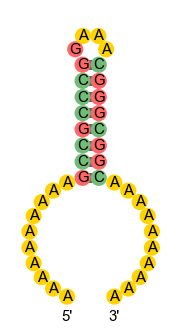

In [125]:
row = long_ctrl.iloc[-1,:]
try:
    draw_struct(row.RefSeq, row.TargetStruct)
except:
    print(row.RefSeq, row.TargetStruct)
    print(len(row.RefSeq), len(row.TargetStruct))

In [90]:
import pickle
with open('./data/series_normalized/NNNlib2b_DNA_20211216_normalized.pkl', 'rb') as fh:
    cluster_table = pickle.load(fh)

In [109]:
# conditions = [c for c in cluster_table.columns if c.endswith('_norm')]
var_vec = cluster_table.groupby('SEQID').apply(lambda x: np.nanstd(x, axis=0))

TypeError: Series.name must be a hashable type

In [107]:
np.nanmedian(np.asarray(var_vec.values.tolist()), axis=0)

array([0.17638894, 0.17245928, 0.18547804, 0.20897529, 0.23901219,
       0.2515056 , 0.23988611, 0.27032161, 0.29677652, 0.33947923,
       0.32473714, 0.35006188, 0.33143469, 0.32912175, 0.37132002,
       0.40349751, 0.45275439, 0.21402608])

In [132]:
fluorfile = """/scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green07_Cy3/NNNlib2b_DNA_tile16_focused_green_2_600ms_2012.03.13-13.15
.33.265.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green09_Quench/NNNlib2b_DNA_tile10_focused_green_2_600ms_2012.03
.13-13.38.43.718.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green10_20/NNNlib2b_DNA_tile10_green_600ms_2012.03.13-1
4.03.19.218.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green11_22.5/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-14.5
8.48.937.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green12_25/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-15.05.30.
656.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green13_27.5/NNNlib2b_DNA_tile9_green_600ms_2012.03.13-15.08.56.312.
CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green14_30/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-15.13.24.562.CPflu
or, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green15_32.5/NNNlib2b_DNA_tile6_green_600ms_2012.03.13-15.16.24.906.CPfluor, 
/scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green16_35/NNNlib2b_DNA_tile14_green_600ms_2012.03.13-15.21.02.781.CPfluor, /scra
tch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green17_37.5/NNNlib2b_DNA_tile10_green_600ms_2012.03.13-15.25.09.765.CPfluor, /scratch
/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green18_40/NNNlib2b_DNA_tile2_green_600ms_2012.03.13-15.48.14.546.CPfluor, /scratch/group
s/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green19_42.5/NNNlib2b_DNA_tile8_green_600ms_2012.03.13-16.06.59.484.CPfluor, /scratch/groups/wj
g/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green20_45/NNNlib2b_DNA_tile4_green_600ms_2012.03.13-16.25.20.062.CPfluor, /scratch/groups/wjg/kyx/
NNNlib2b_Nov11/data/fluor_20220314/Green21_47.5/NNNlib2b_DNA_tile1_green_600ms_2012.03.13-16.31.14.671.CPfluor, /scratch/groups/wjg/kyx/NNNl
ib2b_Nov11/data/fluor_20220314/Green22_50/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-16.37.12.953.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_
Nov11/data/fluor_20220314/Green23_52.5/NNNlib2b_DNA_tile18_green_600ms_2012.03.13-16.42.03.109.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov
11/data/fluor_20220314/Green24_55/NNNlib2b_DNA_tile13_green_600ms_2012.03.13-16.46.17.406.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/da
ta/fluor_20220314/Green25_57.5/NNNlib2b_DNA_tile12_green_600ms_2012.03.13-16.50.54.828.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/
fluor_20220314/Green26_60/NNNlib2b_DNA_tile4_green_600ms_2012.03.13-16.55.05.921.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_
20220314/Green27_20/NNNlib2b_DNA_tile11_green_600ms_2012.03.13-17.23.27.203.CPfluor, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/tmp/NNNlib2
b_DNA_20220314.map, /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/aligned/ConsensusReads_20220316_exact.CPseq"""

In [137]:
print(fluorfile.replace('\n', '').replace(',', '\n'))

/scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green07_Cy3/NNNlib2b_DNA_tile16_focused_green_2_600ms_2012.03.13-13.15.33.265.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green09_Quench/NNNlib2b_DNA_tile10_focused_green_2_600ms_2012.03.13-13.38.43.718.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green10_20/NNNlib2b_DNA_tile10_green_600ms_2012.03.13-14.03.19.218.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green11_22.5/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-14.58.48.937.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green12_25/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-15.05.30.656.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green13_27.5/NNNlib2b_DNA_tile9_green_600ms_2012.03.13-15.08.56.312.CPfluor
 /scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/fluor_20220314/Green14_30/NNNlib2b_DNA_tile15_green_600ms_2012.03.13-15.13.24.562.CPfluor
 /scratch/groups/wjg/kyx/NNN

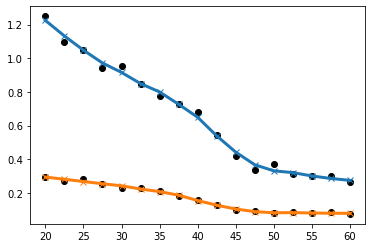

In [33]:
smooth = 'savgol_7_2'
if smooth.startswith('savgol'):
    win_len, poly = int(smooth.split('_')[1]), int(smooth.split('_')[2])
    max_median_s = savgol_filter(max_median, win_len, poly)
    min_median_s = savgol_filter(min_median, win_len, poly)

plt.plot(df.index, max_median,'ko')
plt.plot(df.index, min_median,'ko')
plt.plot(df.index, max_median_s, '-x', linewidth=3)
plt.plot(df.index, min_median_s, '-x', linewidth=3)

## Looking at 150mM salt experiment

### Some QC plots

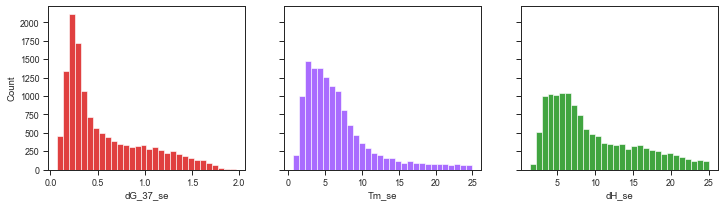

In [37]:
plotting.plot_se_dist(salt)

se of $dG_{37}$ is high for the variants that are incomplete. It mostly affects estimating dH but not Tm.

<AxesSubplot:xlabel='fmax', ylabel='Tm_se'>

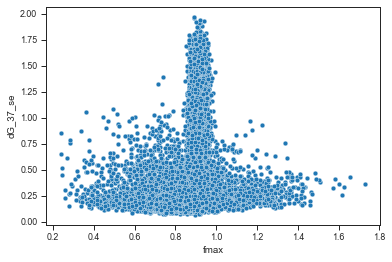

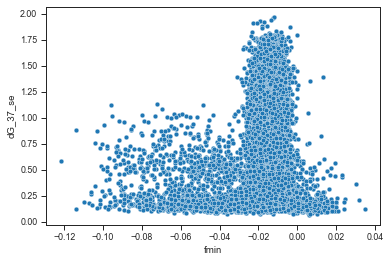

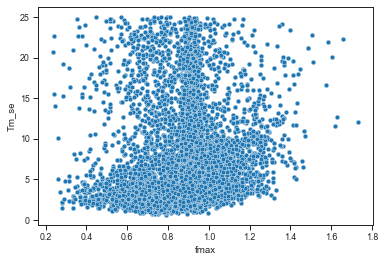

In [41]:

sns.scatterplot(data=salt, x='fmax', y='dG_37_se')
plt.figure()
sns.scatterplot(data=salt, x='fmin', y='dG_37_se')
plt.figure()
sns.scatterplot(data=salt, x='fmax', y='Tm_se')

In [28]:
salt.columns

Index(['Tm', 'Tm_lb', 'Tm_se', 'Tm_ub', 'dG_37', 'dG_37_lb', 'dG_37_se',
       'dG_37_ub', 'dH', 'dH_lb', 'dH_se', 'dH_ub', 'dS', 'dS_lb', 'dS_se',
       'dS_ub', 'fmax', 'fmax_lb', 'fmax_se', 'fmax_ub', 'fmin', 'fmin_lb',
       'fmin_se', 'fmin_ub', 'rsqr', 'RMSE', 'enforce_fmax', 'enforce_fmin',
       'dof', 'chisq', 'chisq_global_sigma', 'Green10_20_norm',
       'Green11_22.5_norm', 'Green12_25_norm', 'Green13_27.5_norm',
       'Green14_30_norm', 'Green15_32.5_norm', 'Green16_35_norm',
       'Green17_37.5_norm', 'Green18_40_norm', 'Green19_42.5_norm',
       'Green20_45_norm', 'Green21_47.5_norm', 'Green22_50_norm',
       'Green23_52.5_norm', 'Green24_55_norm', 'Green25_57.5_norm',
       'Green26_60_norm', 'Green10_20_norm_std', 'Green11_22.5_norm_std',
       'Green12_25_norm_std', 'Green13_27.5_norm_std', 'Green14_30_norm_std',
       'Green15_32.5_norm_std', 'Green16_35_norm_std', 'Green17_37.5_norm_std',
       'Green18_40_norm_std', 'Green19_42.5_norm_std', 'Green20_45

<AxesSubplot:xlabel='Green26_60_norm', ylabel='Tm_se'>

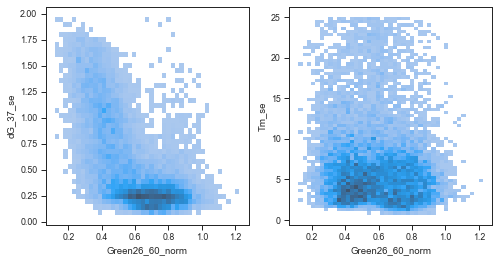

In [40]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(data=salt, x='Green26_60_norm', y='dG_37_se', ax=ax[0])
sns.histplot(data=salt, x='Green26_60_norm', y='Tm_se', ax=ax[1])

### Compare across experiments by salt concentration

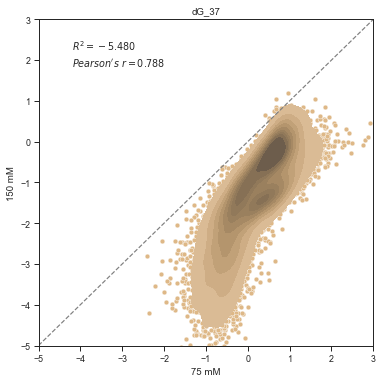

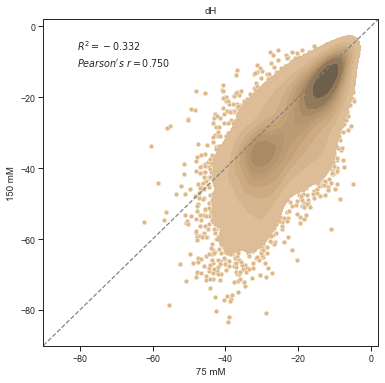

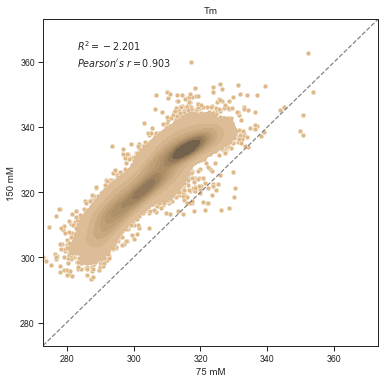

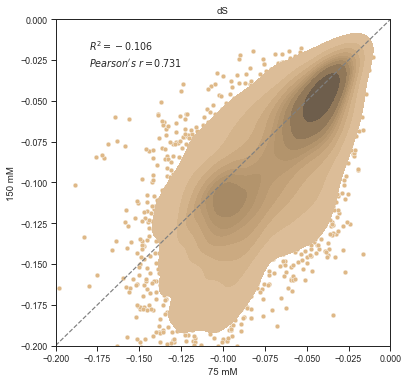

In [62]:
def plot_salt_comparison(param, lim):
    plotting.plot_rep_comparison(r2, salt, param, lim, kind='kde_scatter')
    plt.xlabel('75 mM')
    plt.ylabel('150 mM')
    util.save_fig(f'./fig/high_salt/salt_{param}_comparison.pdf')
    
plot_salt_comparison('dG_37', [-5,3])
plot_salt_comparison('dH', [-90,2])
plot_salt_comparison('Tm', [273,373])
plot_salt_comparison('dS', [-.2,0])

In [63]:
df = r2[['dH']].merge(salt[['dH']], left_index=True, right_index=True)

In [68]:
df = df.join(annotation)
df['ddH'] = df.dH_y - df.dH_x
df['GC'] = df.RefSeq.apply(util.get_GC_content)

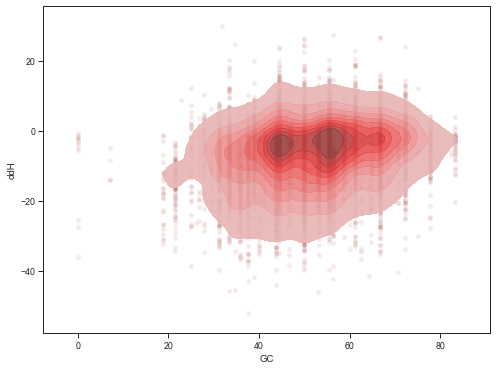

In [95]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, y='ddH', x='GC', color='brown', alpha=0.1)
sns.kdeplot(data=df, y='ddH', x='GC', fill=True, alpha=0.9, color='brown')
# plt.ylim([-40, 20])
util.save_fig('./fig/high_salt/ddH_GC.pdf')

In [91]:
import statsmodels.api as sm

In [93]:
mod = sm.OLS(df.ddH, sm.add_constant(df.GC))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ddH   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     415.5
Date:                Sun, 20 Mar 2022   Prob (F-statistic):           1.21e-90
Time:                        21:19:59   Log-Likelihood:                -38209.
No. Observations:               10740   AIC:                         7.642e+04
Df Residuals:                   10738   BIC:                         7.644e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.8623      0.364    -38.074      0.0

### Compare to NUPACK

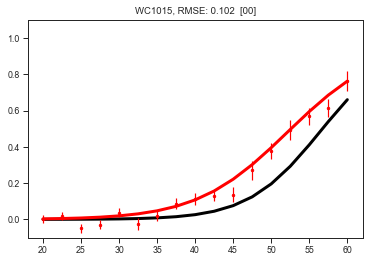

In [14]:
"""
Plot a single variant
"""
fig, ax = plt.subplots()
row = salt.query('Series == "WatsonCrick"').iloc[10,:]
plotting.plot_corrected_NUPACK_curve(row, sodium=0.15, ax=ax)
plotting.plot_renorm_actual_and_expected_fit(row, ax=ax, c='r')

#### Correlation plots

In [100]:
def plot_nupack_comparison_by_series(vf, param, sodium=0.75,
    annotation=None, lim=None):
    df = vf.copy()
    if annotation is not None:
        df = df.join(annotation)
        
    if param in ['dG_37', 'Tm']:
        suffix = '_NUPACK_salt_corrected'
        df['GC'] = df.RefSeq.apply(get_GC_content)
        df['Tm_NUPACK_salt_corrected'] = df.apply(lambda row: util.get_Na_adjusted_Tm(Tm=row.Tm_NUPACK, dH=row.dH_NUPACK, GC=row.GC, Na=sodium), axis=1)
    else:
        suffix = '_NUPACK'

    if param == 'dG_37':
        df['dG_37_NUPACK_salt_corrected'] = df.apply(lambda row: get_dG(dH=row.dH_NUPACK, Tm=row.Tm_NUPACK_salt_corrected+273.15, celsius=37), axis=1)

    df.loc[df.Series == 'External', 'Series'] = 'Control'

    series = df.groupby('Series').apply(len).sort_values(ascending=False)
    l = np.abs(lim[1] - lim[0])

    fig, ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
    ax = ax.flatten()

    for i, s in enumerate(series.index[:12]):
        series_df = df.query('Series == "%s"'%s)
        print('Series %s,  %d variants' % (s, len(series_df)))
        ax[i].plot(lim, lim, '--', c='gray')
        if len(series_df) > 100:
            sns.scatterplot(data=series_df, x=param+suffix, y=param,
                color=palette[i % len(palette)], alpha=.1, ax=ax[i])
            sns.kdeplot(data=series_df, x=param+suffix, y=param,
                color=palette[i % len(palette)], fill=False, ax=ax[i])
            rsqr = r2_score(series_df[param+suffix], series_df[param])
            pearson, _ = pearsonr(series_df[param+suffix], series_df[param])
            ax[i].text(lim[0] + 0.1*l, lim[1] - 0.1*l, r'$R^2 = %.3f$'%rsqr, va='bottom')
            ax[i].text(lim[0] + 0.1*l, lim[1] - 0.15*l, r"$Pearson's\ r = %.3f$"%pearson, va='bottom')
        else:
            sns.scatterplot(data=series_df, x=param+suffix, y=param,
                color=palette[i % len(palette)], ax=ax[i])

        ax[i].set_xlim(lim)
        ax[i].set_ylim(lim)    
        ax[i].set_xlabel('NUPACK')
        ax[i].set_ylabel('MANifold')
        ax[i].set_title('%s, N=%d'%(s, series[s]))

    plt.suptitle(param)

    return df



Series MisMatches,  5515 variants
Series Bulges,  4873 variants
Series TETRAloop,  1681 variants
Series WatsonCrick,  646 variants
Series TRIloop,  450 variants
Series Control,  65 variants


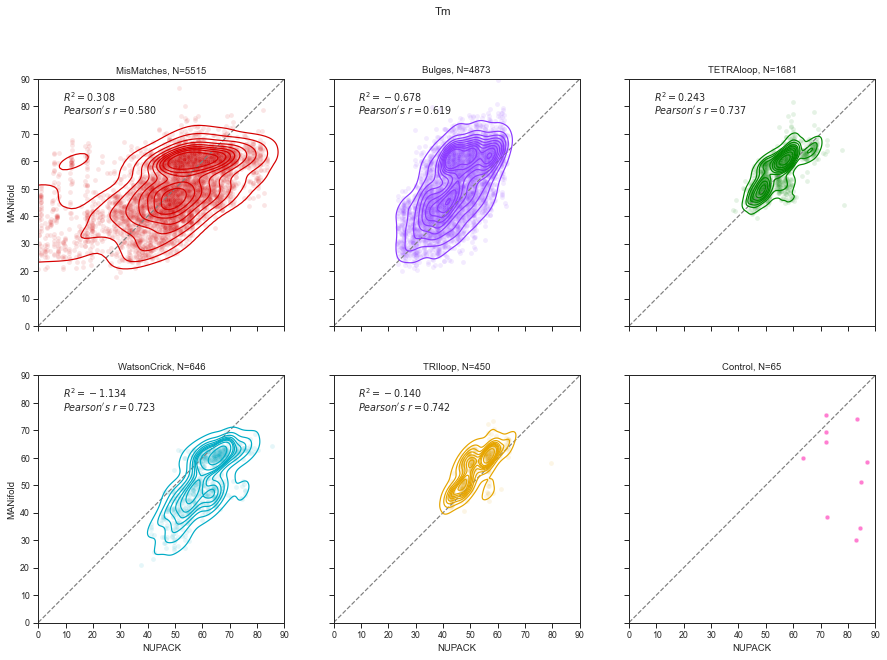

In [105]:
plot_nupack_comparison_by_series(salt, 'dG_37', sodium=0.15, lim=[-7,3])
util.save_fig('./fig/high_salt/nupack_corr_dG_37.pdf')

plot_nupack_comparison_by_series(salt, 'Tm', sodium=0.15, lim=[0,90])
util.save_fig('./fig/high_salt/nupack_corr_Tm_150mM.pdf')

Series MisMatches,  8880 variants
Series Bulges,  8738 variants
Series TETRAloop,  3805 variants
Series WatsonCrick,  2374 variants
Series TRIloop,  956 variants
Series Control,  96 variants
Series MisMatches,  8880 variants
Series Bulges,  8738 variants
Series TETRAloop,  3805 variants
Series WatsonCrick,  2374 variants
Series TRIloop,  956 variants
Series Control,  96 variants


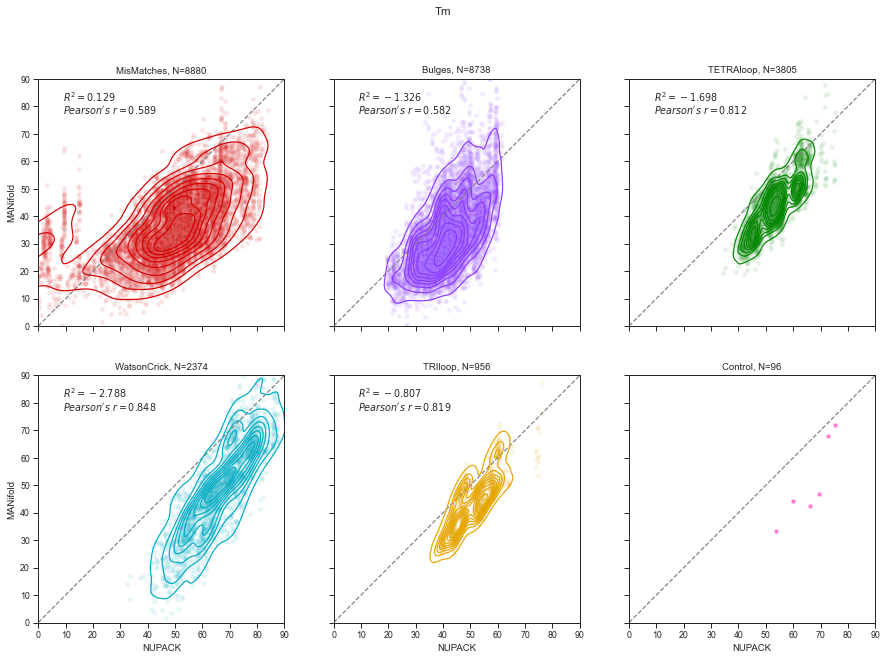

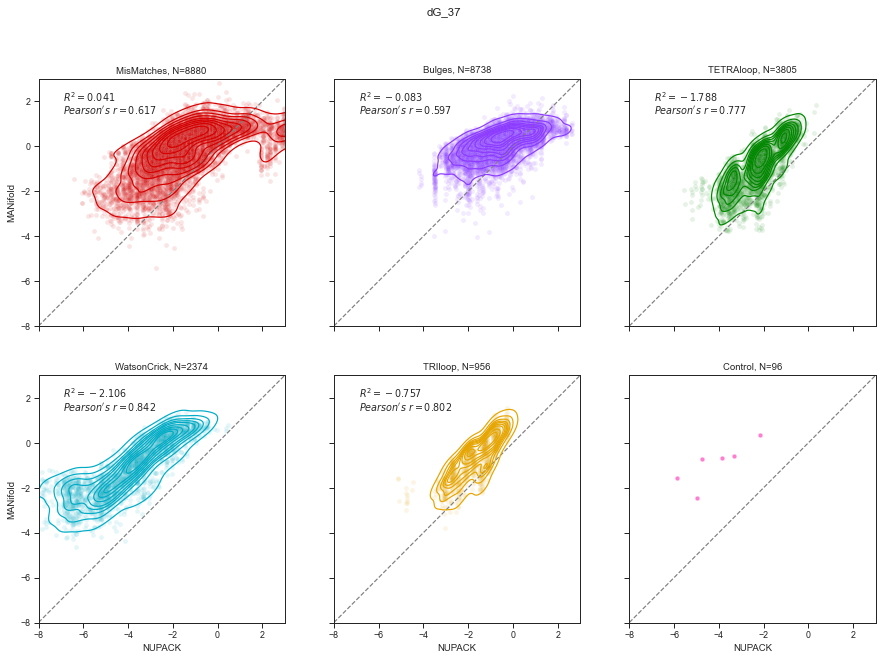

In [108]:
plot_nupack_comparison_by_series(r2, 'Tm', sodium=0.075, lim=[0,90], annotation=annotation)
util.save_fig('./fig/high_salt/nupack_corr_Tm_75mM.pdf')

plot_nupack_comparison_by_series(r2, 'dG_37', sodium=0.075, lim=[-8,3], annotation=annotation)
util.save_fig('./fig/high_salt/nupack_corr_dG_37_75mM.pdf')

#### % different from NUPACK

In [120]:
salt[util.is_diff_nupack(salt, 'dG_37')]

,Tm,Tm_lb,Tm_se,Tm_ub,dG_37,dG_37_lb,dG_37_se,dG_37_ub,dH,dH_lb,...,dS_NUPACK,Tm_NUPACK,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
BNN105,60.941540,38.338494,13.345034,85.323873,-0.497572,-0.844286,0.216392,-0.048758,-6.930873,-12.201998,...,-0.124359,65.385520,-6.541180,((((((....)))..))),-3.53,66.666667,57.335407,-2.590495,-42.1,-0.124359
BNN106,42.814462,33.436754,4.849401,50.855046,-0.249583,-0.669392,0.232456,0.201177,-15.370520,-21.106424,...,-0.124359,65.385520,-4.413441,(((..(((....)))))),-3.53,61.111111,56.996034,-2.549881,-42.1,-0.124359
BNN107,47.041996,29.529288,10.721506,72.657842,-0.290920,-0.634667,0.303113,0.418414,-9.235946,-18.359637,...,-0.124359,65.385520,-5.347911,((((((....)))..))),-3.53,61.111111,56.996034,-2.549881,-42.1,-0.124359
BNN109,58.988994,45.789502,7.585183,72.704343,-0.754464,-1.139748,0.207805,-0.345526,-11.228145,-18.689578,...,-0.124359,65.385520,-5.508532,((((((....)))..))),-3.53,66.666667,57.335407,-2.590495,-42.1,-0.124359
BNN111,73.401699,55.401344,16.720832,108.141673,-1.134042,-2.335799,0.400897,-0.634813,-10.546758,-34.535408,...,-0.155860,61.124204,-4.418206,((((((....))).))),-3.76,70.588235,53.313649,-2.603479,-52.1,-0.155860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC984,27.304114,21.709450,6.109580,43.908074,0.543576,-0.229846,0.375305,1.195185,-15.786689,-24.205386,...,-0.097985,60.575074,-2.737490,(((((....))))),-2.31,21.428571,49.761490,-1.292307,-32.7,-0.097985
WC985,48.471415,44.051842,6.458407,69.816274,-1.111570,-1.536855,0.196225,-0.692929,-29.425682,-46.585414,...,-0.127358,66.837215,-3.893504,((((((....)))))),-3.80,31.250000,56.623595,-2.576621,-43.3,-0.127358
WC990,40.746054,35.646227,2.843884,46.130937,-0.302929,-0.604944,0.205534,0.155421,-25.401925,-56.174099,...,-0.098501,69.994681,-3.654193,(((((....))))),-3.25,35.714286,60.053772,-2.338561,-33.8,-0.098501


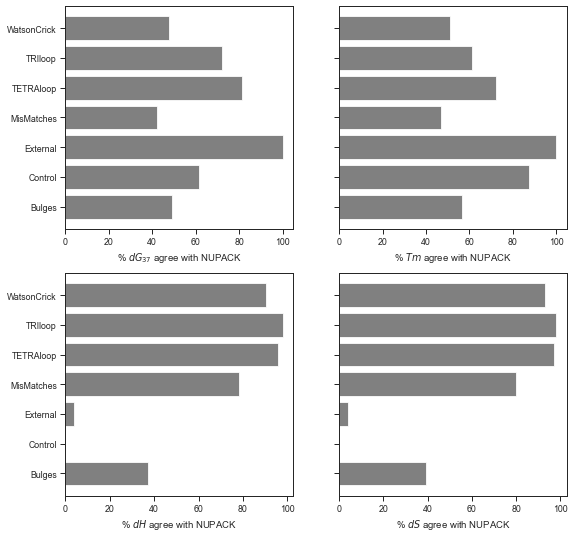

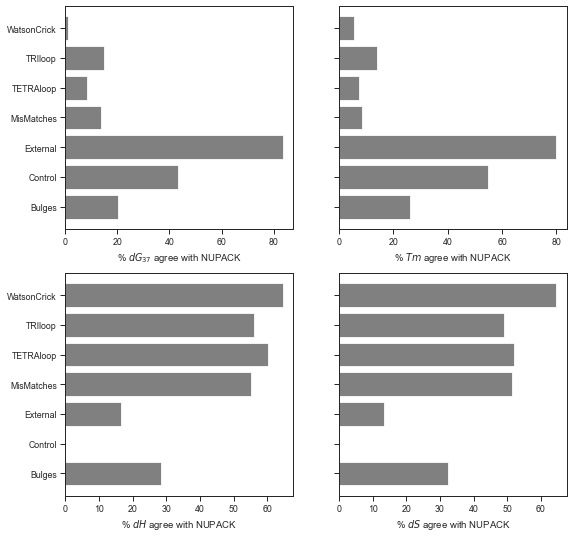

In [17]:
def plot_perc_agree_nupack(vf, param, annotation):
    df = pd.DataFrame(util.is_diff_nupack(vf, param), columns=[f'{param}_diff']).join(annotation)
    perc_agree_nupack = (1 - df.groupby('Series')[f'{param}_diff'].apply(sum) / df.groupby('Series')[f'{param}_diff'].apply(len)) * 100.0
    plt.barh(perc_agree_nupack.index, perc_agree_nupack, fill=True, color='grey')
    
    p = param
    if p == 'dG_37':
        p = 'dG_{37}'
    plt.xlabel(f'% ${p}$ agree with NUPACK')
    return perc_agree_nupack
    
fig, ax = plt.subplots(2,2,figsize=(9,9), sharey=True)
ax = ax.flatten()
for i,param in enumerate(['dG_37', 'Tm', 'dH', 'dS']):
    plt.sca(ax[i])
    plot_perc_agree_nupack(salt, param, annotation)
    
util.save_fig('./fig/NUPACK/perc_agree_with_nupack_150mM.pdf')


fig, ax = plt.subplots(2,2,figsize=(9,9), sharey=True)
ax = ax.flatten()
for i,param in enumerate(['dG_37', 'Tm', 'dH', 'dS']):
    plt.sca(ax[i])
    plot_perc_agree_nupack(r1, param, annotation)
    
util.save_fig('./fig/NUPACK/perc_agree_with_nupack_75mM.pdf')

In [136]:
perc_agree_nupack.index

Index(['Bulges', 'Control', 'External', 'MisMatches', 'TETRAloop', 'TRIloop',
       'WatsonCrick'],
      dtype='object', name='Series')

# ArrayData

In [139]:
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
replicate_df

,name,replicate,chip,filename,drop_last,reverse,sodium,notes
0,r1,211022,Oct06,./data/fitted_variant/NNNlib2b_DNA_20211022_v6...,False,False,0.075,NaN
1,r2,211216,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211216.CP...,False,False,0.075,NaN
2,r3,211221,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211221_v6...,True,False,0.075,NaN
3,rev,211223,Nov11,./data/fitted_variant/NNNlib2b_DNA_20211223_v6...,True,True,0.075,reversed
4,salt,220314,Nov11,./data/fitted_variant/NNNlib2b_DNA_20210314_v1...,True,False,0.150,NaN


86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
80.98% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


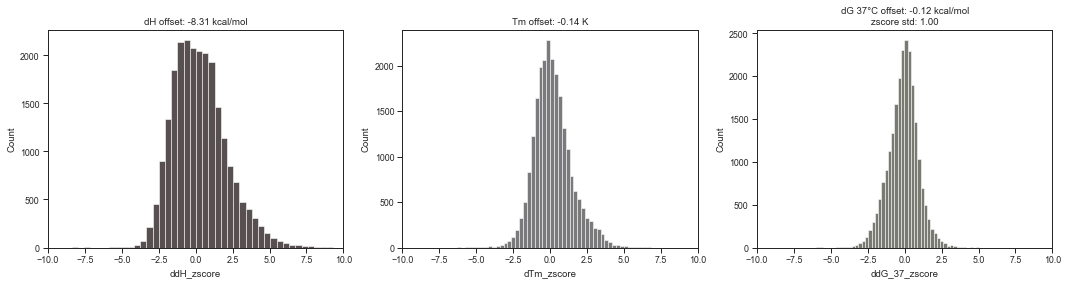

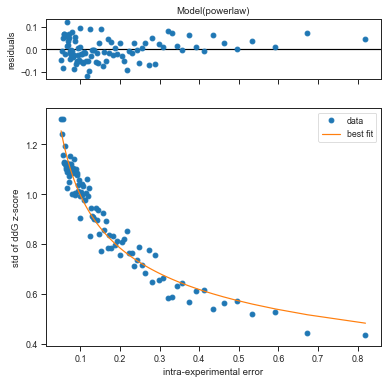

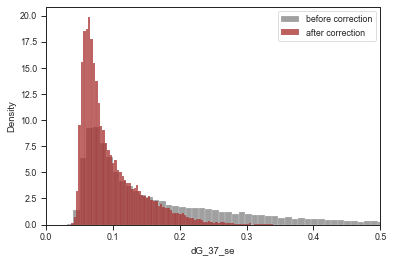

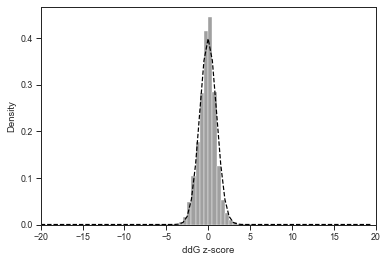

In [194]:
from nnn.arraydata import ErrorAdjust, ArrayData
arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220316.tsv',
                      learn_error_adjust_from=('r1', 'r2'))

In [198]:
sigma = 0.03
ej.A.eval(x=sigma), arraydata.error_adjust.adjust_sigma(sigma)

(1.3678699430786327, 1.5068104634387056)

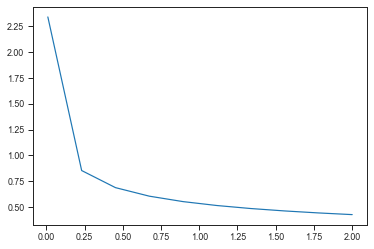

In [191]:

sigma = np.linspace(.01, 2.0,10)
plt.plot(sigma, arraydata.error_adjust.adjust_sigma(sigma))

In [164]:
arraydata.error_adjust.adjust_sigma(0.6)

0.7264502512191258

In [183]:
arraydata.error_adjust.A

0.5330101890721478

In [ ]:
revdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220316.tsv',
                      learn_error_adjust_from=('211022', '211221'))